In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Loading Data

In [4]:
ds = pd.read_csv('/content/drive/MyDrive/datasets/code_jam_may25/data/final_labels_SG2.csv', sep=';')

In [5]:
ds

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']
...,...,...,...,...,...,...,...,...
3669,You’ve heard of Jim Crow and Southern Segregat...,http://feedproxy.google.com/~r/breitbart/~3/ei...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['ALL']
3670,Young female athletes’ dreams and accomplishme...,http://feedproxy.google.com/~r/breitbart/~3/eW...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,"['dashed', '""identify""']"
3671,"Young white men, reacting to social and educat...",https://thefederalist.com/2016/05/23/how-anti-...,Federalist,white-nationalism,right,Biased,Expresses writer’s opinion,"['evil', 'white']"
3672,Young women taking part in high school and col...,NaN,Breitbart,sport,right,Biased,Somewhat factual but also opinionated,"['dashed', '""identify""']"


In [6]:
# Nan values
ds.isna().sum()

,0
text,0
news_link,32
outlet,0
topic,0
type,1000
label_bias,0
label_opinion,0
biased_words,0


In [7]:
ds.iloc[0][0]

<ipython-input-7-a6d6193478d9>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds.iloc[0][0]


'"Orange Is the New Black" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.'

In [8]:
ds['text']

,text
0,"""Orange Is the New Black"" star Yael Stone is r..."
1,"""We have one beautiful law,"" Trump recently sa..."
2,"...immigrants as criminals and eugenics, all o..."
3,...we sounded the alarm in the early months of...
4,[Black Lives Matter] is essentially a non-fals...
...,...
3669,You’ve heard of Jim Crow and Southern Segregat...
3670,Young female athletes’ dreams and accomplishme...
3671,"Young white men, reacting to social and educat..."
3672,Young women taking part in high school and col...


# Useful functions

In [9]:
from transformers import BertTokenizer, BertModel
import torch
import math
import numpy as np
from tqdm import tqdm

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    # Tokenize the texts
    ids_list = []
    attention_mask_list = []

    # Tokenize each text and create the input_ids and attention masks
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,          # Add [CLS] and [SEP]
            max_length=max_length,            # Pad or truncate text to max length
            padding='max_length',             # Pad to max length
            return_attention_mask=True,       # Create attention mask
            return_tensors='pt',              # Return PyTorch tensors
            truncation=True
        )
        ids_list.append(encoded['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoded['attention_mask'].squeeze().tolist())

    # Set device
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)

    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # Getting embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            model.eval()
            # Extracting the hidden state of the [CLS] token for each batch
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        # We only take the embedding corresponding to the [CLS] token (first token)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
def train_val_test_split (df, rstate = 42, shuffle=True, stratify=None):
    if stratify != None:
        strat=df[stratify]
    else:
        strat = None
    train_set, test_set = train_test_split(df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)

    if stratify!=None:
        strat=test_set[stratify]
    else:
        strat = None
    val_set, test_set=train_test_split(test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)

    return (train_set, val_set, test_set)

# Data Preprocessing

In [11]:
label_counts = ds['label_bias'].value_counts()
valid_labels = label_counts[label_counts > 1].index

ds = ds[ds['label_bias'].isin(valid_labels)]

In [12]:
# Only keeping input and output
df = ds[['text', 'label_bias']]

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label_bias'])


<ipython-input-13-e6a932c8f2b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_encoded'] = le.fit_transform(df['label_bias'])


In [14]:
df['label_encoded'].value_counts()

,count
label_encoded,
1,1863
0,1810


In [15]:
# Splitting in train and test
train_set, val_set, test_set = train_val_test_split(df, stratify='label_encoded')
xtrain, ytrain = train_set['text'], train_set['label_encoded']
xval, yval = val_set['text'], val_set['label_encoded']
xtest, ytest = test_set['text'], test_set['label_encoded']


# Model

In [16]:
xtrain

,text
3525,"When carrying a firearm, you have the ultimate..."
905,"During the campaign, it was clear that much of..."
397,As proof of the racism still inherent in the g...
2698,The Heroes Act contains many leftist provision...
171,Activists’ frustration has only compounded sin...
...,...
774,"Curiously, both Kelly and Yen seem unaware of ..."
2129,President-elect Joe Biden campaigned to have a...
1806,Netflix disappointed investors when the stream...
1289,Immigration Voice claims to be an independent ...


In [17]:
embeddings_train = BERT_text_to_embeddings(xtrain)
embeddings_val = BERT_text_to_embeddings(xval)
embeddings_test = BERT_text_to_embeddings(xtest)

Using the cuda device.


100%|██████████| 23/23 [01:07<00:00,  2.96s/it]


Using the cuda device.


100%|██████████| 8/8 [00:22<00:00,  2.75s/it]


Using the cuda device.


100%|██████████| 8/8 [00:22<00:00,  2.77s/it]


In [18]:
print(le.classes_)
print(type(le.classes_[0]))


['Biased' 'Non-biased']
<class 'str'>


## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression()
clf.fit(embeddings_train, ytrain)

y_pred = clf.predict(embeddings_test)
print(classification_report(ytest, y_pred, target_names=[str(label) for label in le.classes_]))


              precision    recall  f1-score   support

      Biased       0.72      0.71      0.71       362
  Non-biased       0.72      0.73      0.73       373

    accuracy                           0.72       735
   macro avg       0.72      0.72      0.72       735
weighted avg       0.72      0.72      0.72       735



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## XGB Classifier

In [20]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(embeddings_train, ytrain)

y_pred = clf.predict(embeddings_test)
print(classification_report(ytest, y_pred, target_names=[str(label) for label in le.classes_]))

              precision    recall  f1-score   support

      Biased       0.75      0.72      0.74       362
  Non-biased       0.74      0.77      0.75       373

    accuracy                           0.74       735
   macro avg       0.74      0.74      0.74       735
weighted avg       0.74      0.74      0.74       735



## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(embeddings_train, ytrain)

y_pred = rf_clf.predict(embeddings_test)
print(classification_report(ytest, y_pred, target_names=[str(label) for label in le.classes_]))

              precision    recall  f1-score   support

      Biased       0.74      0.68      0.71       362
  Non-biased       0.71      0.77      0.74       373

    accuracy                           0.73       735
   macro avg       0.73      0.73      0.73       735
weighted avg       0.73      0.73      0.73       735



## Neural Network with Keras

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

ytrain_nn = ytrain.values
yval_nn = yval.values
ytest_nn = ytest.values

In [47]:
model = Sequential([
    Dense(512, activation='gelu', input_shape=(embeddings_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='gelu'),
    Dropout(0.3),
    # Dense(128, activation='gelu'),
    # Dropout(0.3),
    # Dense(64, activation='gelu'),
    # Dropout(0.3),
    Dense(len(set(ytrain)), activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # use this for integer labels
    metrics=['accuracy']
)



In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    embeddings_train, ytrain,
    validation_data=(embeddings_val, yval),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6165 - loss: 0.6439 - val_accuracy: 0.7510 - val_loss: 0.5172
Epoch 2/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7166 - loss: 0.5550 - val_accuracy: 0.7633 - val_loss: 0.4878
Epoch 3/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7421 - loss: 0.5138 - val_accuracy: 0.7837 - val_loss: 0.4758
Epoch 4/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7681 - loss: 0.4885 - val_accuracy: 0.7864 - val_loss: 0.4662
Epoch 5/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7593 - loss: 0.4857 - val_accuracy: 0.7796 - val_loss: 0.4701
Epoch 6/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8016 - loss: 0.4500 - val_accuracy: 0.7932 - val_loss: 0.4617
Epoch 7/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7941 - loss: 0.4321 - val_accuracy: 0.7701 - val_loss: 0.4698
Epoch 8/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7870 - loss: 0.4398 - val_accuracy: 0.7469 - val_loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


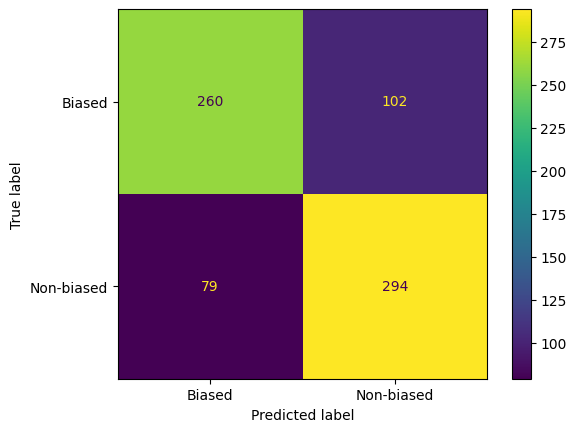

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ypred = model.predict(embeddings_test).argmax(axis=1)
ConfusionMatrixDisplay.from_predictions(ytest, ypred, display_labels=le.classes_)
